## Image classification with CNN 

Data set link: https://www.kaggle.com/alxmamaev/flowers-recognition

##  Data input & visualization

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

C:\Users\tient\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
path = 'data/flowers/flowers/'

In [5]:
os.listdir(path)

['training', 'validation']

In [6]:
sample = os.listdir(path+'training/daisy')[:5]; sample

['100080576_f52e8ee070_n.jpg',
 '10140303196_b88d3d6cec.jpg',
 '10172379554_b296050f82_n.jpg',
 '10172567486_2748826a8b.jpg',
 '10172636503_21bededa75_n.jpg']

In [7]:
img = plt.imread(path+'training/daisy/'+sample[0])

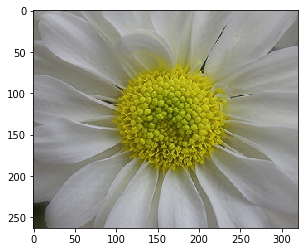

In [8]:
plt.imshow(img)

In [9]:
img.shape

(263, 320, 3)

## Split data set into training & validation sets 

From the files in the data set, manually select 20% of the data and put it in the validation set.

## Training model 

In [12]:
sz = 224

In [16]:
arch=resnet34
data = ImageClassifierData.from_paths(path, trn_name='training', val_name='validation', tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:15<00:00,  1.12s/it]


epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.742519   0.403809   0.862428  
    1      0.572882   0.378439   0.869364                                                                              
    2      0.452261   0.358112   0.875145                                                                              



[array([0.35811]), 0.8751445096352197]

In [17]:
lrf=learn.lr_find()

 62%|███████████████████████████████████████████▉                           | 34/55 [00:00<00:00, 55.40it/s, loss=1.46]


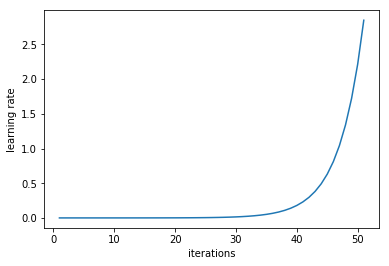

In [18]:
learn.sched.plot_lr()

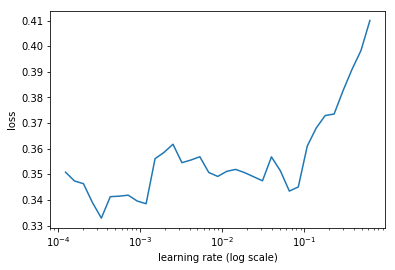

In [20]:
learn.sched.plot()

In [21]:
learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.321582   0.361458   0.871676  
    1      0.393618   0.368815   0.884393                                                                              



[array([0.36882]), 0.8843930646174216]

### Data augmentation

In [22]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [26]:
data = ImageClassifierData.from_paths(path, trn_name='training', val_name='validation', tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)learn.fit(1e-2, 1)

In [27]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.663747   0.399988   0.863584  



[array([0.39999]), 0.8635838148221804]

In [28]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.461598   0.387765   0.865896  
    1      0.492554   0.390095   0.873988                                                                              
    2      0.405901   0.365938   0.882081                                                                              



[array([0.36594]), 0.8820809247865842]

### Fine tuning  

In [29]:
learn.unfreeze()

In [30]:
lr=np.array([1e-4,1e-3,1e-2])

In [31]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.365729   0.362679   0.877457  
    1      0.349838   0.360126   0.882081                                                                              
    2      0.340154   0.348001   0.885549                                                                              
    3      0.391039   0.341395   0.891329                                                                              
    4      0.387532   0.333597   0.895954                                                                              
    5      0.324643   0.352871   0.884393                                                                              
    6      0.34653    0.334768   0.890173                                                                              



[array([0.33477]), 0.8901734103357172]

In [32]:
learn.save('224_all')

In [ ]:
learn.load('224_all')

In [33]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

## Result

In [34]:
accuracy_np(probs, y)

0.9017341040462428

After some data augmentation and further training with differential learning rate annealing, the accuracy is more than 90%

### Analyzing result 

In [35]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [36]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[134   8   5   3   4]
 [  1 189   5   8   8]
 [  3   3 133   1  17]
 [  2   1   1 136   6]
 [  1   1   5   2 188]]


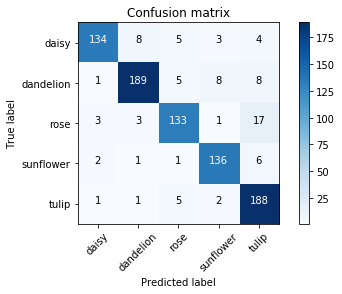

In [37]:
plot_confusion_matrix(cm, data.classes)